In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Rocket import Rocket
from Dynamics import Dynamics
from Plot3D import Plot3D
from MPC import MPC
from Sliding import Sliding
from Quat import Quat

import time
import pylab as pl
from IPython import display

#np.set_printoptions(precision=3,suppress=True)

In [2]:
#https://www.spacex.com/vehicles/falcon-9/

falcon = Rocket("Falcon 9")
falcon.mass = 549054 #kg
falcon.height = 70 #m
falcon.radius = 3.7/2 #m
falcon.max_thrust = 7607e3 #N
falcon.cg_thrust_length = 20 #m
falcon.cg_cp_length = 15 #m
falcon.Cd = 10000.82

falcon.load()
dynamics = Dynamics(falcon)
mpc = MPC(falcon)

In [3]:
""" #https://www.spacex.com/vehicles/falcon-9/

falcon = Rocket("Falcon 9")
falcon.mass = 100 #kg
falcon.height = 7 #m
falcon.radius = 0.37/2 #m
falcon.max_thrust = 1000 #N
falcon.cg_thrust_length = 2 #m
falcon.cg_cp_length = 1.5 #m
falcon.Cd = 10000.82

falcon.load()
dynamics = Dynamics(falcon)
mpc = MPC(falcon) """

' #https://www.spacex.com/vehicles/falcon-9/\n\nfalcon = Rocket("Falcon 9")\nfalcon.mass = 100 #kg\nfalcon.height = 7 #m\nfalcon.radius = 0.37/2 #m\nfalcon.max_thrust = 1000 #N\nfalcon.cg_thrust_length = 2 #m\nfalcon.cg_cp_length = 1.5 #m\nfalcon.Cd = 10000.82\n\nfalcon.load()\ndynamics = Dynamics(falcon)\nmpc = MPC(falcon) '

In [4]:
""" falcon.input(0.05,0.01,1*np.pi/2)
for j in range(100):
        dynamics.update(0.1)

plot3d = Plot3D(falcon, dynamics.states)
plot3d.set(10,5)
plot3d.plot()
plot3d.attitude()
plot3d.origin()
print("Plot?") """

' falcon.input(0.05,0.01,1*np.pi/2)\nfor j in range(100):\n        dynamics.update(0.1)\n\nplot3d = Plot3D(falcon, dynamics.states)\nplot3d.set(10,5)\nplot3d.plot()\nplot3d.attitude()\nplot3d.origin()\nprint("Plot?") '

In [5]:
class Attitude(Sliding):
    def __init__(self,rocket):
        self.rocket = rocket
        eta = np.diag([1,1,1])*152140000.0/rocket.inertia[0,0]*falcon.cg_thrust_length
        lam = 2
        phi = 10
        alpha = 10 #Hz

        B = rocket.inertia/rocket.inertia[0,0]
        B2 = np.linalg.inv(B)
        A = lambda w: B2 @ np.cross(w,rocket.inertia@w,axis=0)
        
        
        super().__init__(eta,lam,phi,alpha,A,B)

    def control(self,state):
        theta = Quat.eulerAngles(state[6:10])
        theta2 = np.array([[theta[0],theta[1],theta[2]]]).T
        print("theta",theta2)
        w = np.array([state[10:13]]).T
        print("w",w)
        c = self.input(theta2,w)
        print("c",c)

    

        print("theta",theta2)
        print("w",w)
        print("c",c)
        import time
        time.sleep(1)
        return [0,c[1,0]/self.rocket.cg_thrust_length*100,-c[2,0]/self.rocket.cg_thrust_length*100]
    
attitude = Attitude(falcon)

attitude.ref = np.array([[0.1,0.1,0]]).T


In [6]:
falcon.max_thrust*falcon.cg_thrust_length/falcon.inertia[0,0]

falcon.max_thrust*falcon.cg_thrust_length


152140000.0

In [7]:
from scipy.integrate import solve_ivp
B2 = np.linalg.inv(falcon.inertia/falcon.inertia[0,0])
def ode(t,state):
    theta_x,theta_y,theta_z,wx,wy,wz,phi= state
    attitude.phi = 10
    w = np.array([[wx,wy,wz]]).T
    u = attitude.input(np.array([[theta_x,theta_y,theta_z]]).T,w)
    th_dot =  B2 @ np.array([[u[0,0],u[1,0],u[2,0]]]).T -B2 @ np.cross(w,(falcon.inertia/falcon.inertia[0,0])@w,axis=0)
    
    phi_dot = 0
    return [wx,wy,wz,th_dot[0,0],th_dot[1,0],th_dot[2,0],phi_dot]

t_eval = np.linspace(0,10,100)
sol = solve_ivp(ode,[0,10],[0,0,0,0,0,0,100],t_eval=t_eval,rtol=1e-1)

print(sol.y)


KeyboardInterrupt: 

In [8]:
plt.plot(sol.t,sol.y[0])

plt.figure()

plt.plot(attitude.inputs[0,:])

NameError: name 'sol' is not defined

In [9]:

control = []
import time
mpc.tf = 20
for i in range(1):
    res = mpc.run(dynamics.state)
    #falcon.inputVec(falcon.mass*res[0][1],falcon.mass*res[1][1],falcon.mass*res[2][1])
    
    
    #falcon.inputNpVec(control)
    
    for j in range(10):
        control = attitude.control(dynamics.state)
        falcon.inputVec(control[0],control[1],control[2])
        print(control)
        dynamics.update(1)

    #print(res[0][1],res[1][1],res[2][1])



theta [[0.        ]
 [0.        ]
 [3.14159265]]
w [[0.]
 [0.]
 [0.]]
c [[ 3.11439789e-01]
 [ 3.11439789e-01]
 [-2.33466914e+03]]
theta [[0.        ]
 [0.        ]
 [3.14159265]]
w [[0.]
 [0.]
 [0.]]
c [[ 3.11439789e-01]
 [ 3.11439789e-01]
 [-2.33466914e+03]]
[0, 1.5571989461948765, 11673.345688221863]
theta [[0.        ]
 [0.        ]
 [3.14159265]]
w [[1.3891342e-07]
 [0.0000000e+00]
 [0.0000000e+00]]
c [[ 3.11436795e-01]
 [ 3.11439789e-01]
 [-2.33466914e+03]]
theta [[0.        ]
 [0.        ]
 [3.14159265]]
w [[1.3891342e-07]
 [0.0000000e+00]
 [0.0000000e+00]]
c [[ 3.11436795e-01]
 [ 3.11439789e-01]
 [-2.33466914e+03]]
[0, 1.5571989461948765, 11673.345688221863]
theta [[0.        ]
 [0.        ]
 [3.14159265]]
w [[2.7782684e-07]
 [0.0000000e+00]
 [0.0000000e+00]]
c [[ 3.11433800e-01]
 [ 3.11439789e-01]
 [-2.33466914e+03]]
theta [[0.        ]
 [0.        ]
 [3.14159265]]
w [[2.7782684e-07]
 [0.0000000e+00]
 [0.0000000e+00]]
c [[ 3.11433800e-01]
 [ 3.11439789e-01]
 [-2.33466914e+03]]


Plot?


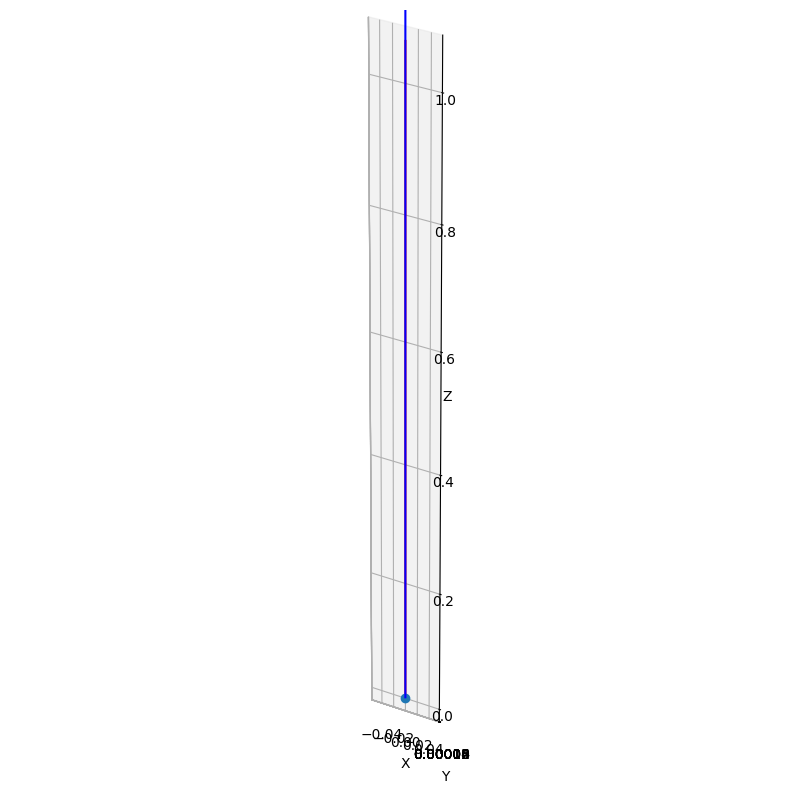

In [10]:
plot3d = Plot3D(falcon, dynamics.states)
plot3d.set(10,5)
plot3d.plot()
plot3d.attitude()
plot3d.origin()
print("Plot?")

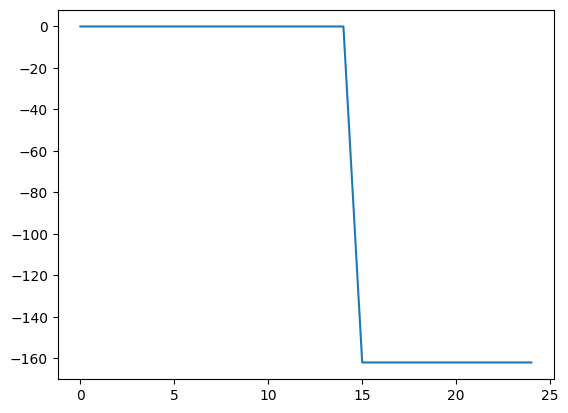

In [ ]:
plt.plot(attitude.inputs[2,:])

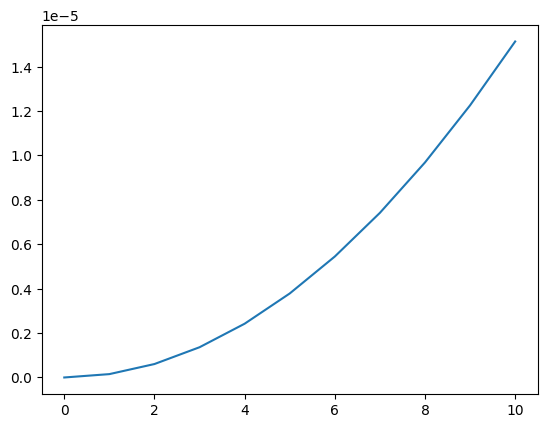

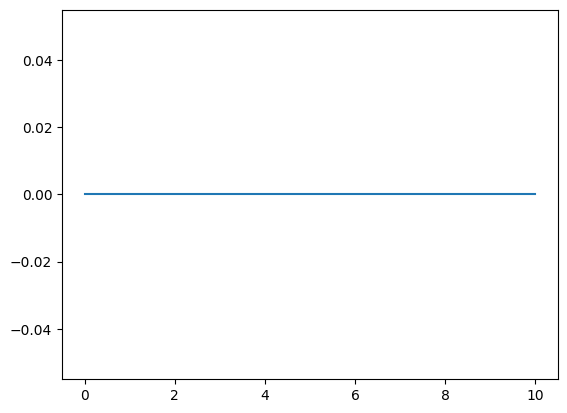

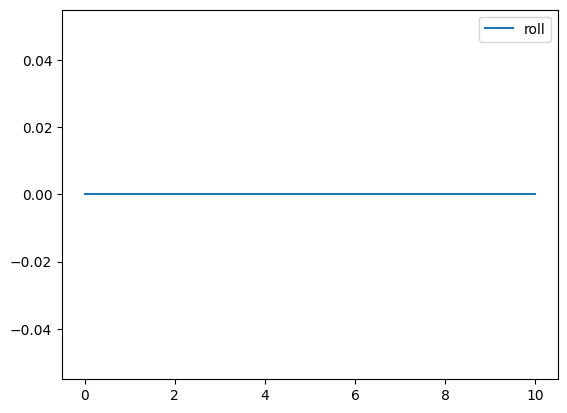

In [ ]:
plot3d.attitudeGraph()